# Parking Availability

## Data
Data set contains:
 - timestamps when a parking session was started and finished: `START_TIME` and `END_TIME`
 - GPS coordinates of the location where a vehicle was parked: `Lon` and `Lat`

In [393]:
from bokeh.io import output_notebook, show
from bokeh.models import (GMapOptions, ColumnDataSource)
from bokeh.plotting import gmap

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import itertools

In [394]:
area_title = 'IJburg'
file_name_prefix = area_title.lower() + '_'
area_lat = 52.355
area_lon = 5
area_zoom = 14

restrict_initial_data_to = 100000

v_area_split_by = 5 #11
h_area_split_by = 5 #11

downsampling_interval_in_minutes = 60

GOOGLE_API_KEY = ''
with open('google_api.key', 'r') as myfile:
    GOOGLE_API_KEY = myfile.read()

In [436]:
df = pd.read_csv('ijburg2017april_sep2.csv')
df.head()

,START_TIME,STOP_TIME,Lon,Lat
0,2017-09-30 21:40:00.250,2017-09-30 21:40:08.593,4.990345,52.358908
1,2017-09-30 20:25:02.600,2017-09-30 20:25:32.710,5.007608,52.350011
2,2017-09-30 19:15:51.303,2017-09-30 19:17:02.013,5.015789,52.354633
3,2017-09-30 19:06:02.730,2017-09-30 20:23:53.023,4.993960,52.354604
4,2017-09-30 18:46:00.973,2017-09-30 22:21:13.130,4.994605,52.357612


Restrict the dataset. Data volumes of big size cannot be handled on the later steps.

In [382]:
df = df.head(restrict_initial_data_to)

Cast timestamps to the propper type.

In [446]:
df.START_TIME = pd.to_datetime(df.START_TIME)
df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
df.dtypes

START_TIME    datetime64[ns]
STOP_TIME     datetime64[ns]
Lon                  float64
Lat                  float64
dtype: object

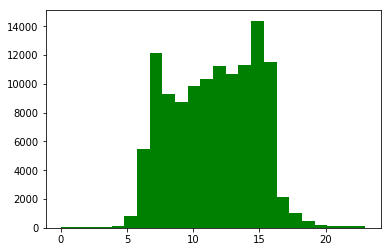

In [454]:
n, bins, patches = plt.hist(df['START_TIME'].dt.hour.values, 24, facecolor='green')

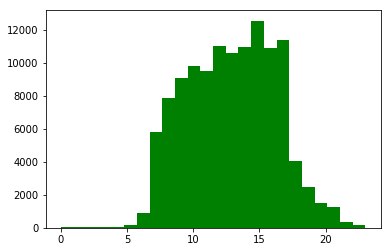

In [455]:
n, bins, patches = plt.hist(df['STOP_TIME'].dt.hour.values, 24, facecolor='green')

## Data visualization

Let's plot the points we have on the map

In [280]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)
plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values)
)

plot.circle(x="lon", y="lat", size=1, fill_color='blue', fill_alpha=0.8, source=source)
output_notebook()

show(plot)

Loading BokehJS ...

## Area split

We don't want to predict availability for each location but for bigger zone. Let's group locations into squared areas. 

We will mark each area by its index and each pair of Lat & Lon can be mapped to the index. 

`index = lon * amount_of_cols + lat`


In [397]:
class CoordinatesMapper(object):
    def __init__(self, minLon, minLat, maxLon, maxLat, hCount = 11, vCount = 11):
        ''' Maps lat lon to a cell.
            Keyword arguments:
            minLon -- min lon in data set
            minLat -- min lat in data set
            maxLon -- max lon in data set
            maxLat -- max lat in data set
            hCount -- amount of areas horisontally
            vCount -- amount of areas vertically
        '''
        self._ndig = 3
        self._minLon = minLon
        self._minLat = minLat
        self._maxLon = maxLon
        self._maxLat = maxLat
        self._hCount = hCount
        self._vCount = vCount
        self._cell_width_lon = round((self._maxLon - self._minLon) / self._hCount, self._ndig)
        self._cell_height_lat = round((self._maxLat - self._minLat) / self._vCount, self._ndig)
        
    def toIndex(self, lon, lat):
        y = int(round(lat - self._minLat, self._ndig) / self._cell_height_lat)
        x = int((lon - self._minLon) / self._cell_width_lon)
        
        return self._hCount * y + x

Add a new column that will hold the area index

In [398]:
mapper = CoordinatesMapper(df.Lon.min(), df.Lat.min(), df.Lon.max(), df.Lat.max(), hCount = h_area_split_by, vCount = v_area_split_by)
df['zone_index'] = df.apply(lambda row: mapper.toIndex(row['Lon'] ,row['Lat']), axis = 1)
print ('Area is split into {0} unique subareas'.format( df['zone_index'].nunique()))

Area is split into 31 unique subareas


## Areas visualization

Let's display the areas after the split.


In [283]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)

plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '00ffff', "#880977"]

points_colors = df.apply(lambda row: colors[int(row['zone_index'] % len(colors))] , axis = 1).values

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values,
        color = points_colors
    )
)

plot.circle(x="lon", y="lat", size=2, line_color='color', fill_color='color', fill_alpha=1, source=source)
output_notebook()

show(plot)

Loading BokehJS ...

## Downsample the time intervals

In [284]:
# The following approach is wrong.
#df['same_time_parkings'] = df.apply(lambda row:  df[(row.zone_index == df.zone_index) & (row.START_TIME < df.STOP_TIME) & (row.STOP_TIME > df.START_TIME)]['START_TIME'].count(), axis = 1)
#df.groupby('zone_index')['same_time_parkings'].max()

In [399]:
zones = df.zone_index.unique()
zones.sort()
zones

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [400]:
period_start = df.START_TIME.min().normalize()
period_end = df.STOP_TIME.max().normalize()

print('{0} - {1}'.format(period_start, period_end))

2017-04-01 00:00:00 - 2017-10-01 00:00:00


In [401]:
timestamps = pd.date_range(period_start, period_end, freq='{0}min'.format(downsampling_interval_in_minutes)).values
timestamps

array(['2017-04-01T00:00:00.000000000', '2017-04-01T01:00:00.000000000',
       '2017-04-01T02:00:00.000000000', ...,
       '2017-09-30T22:00:00.000000000', '2017-09-30T23:00:00.000000000',
       '2017-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [402]:
lists = [timestamps, zones]
zones_availability = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone_index'])
zones_availability = zones_availability.sort_values(by=['zone_index', 'timestamp'])
zones_availability['parked'] = 0
zones_availability.head()

,timestamp,zone_index,parked
0,2017-04-01 00:00:00,0,0
31,2017-04-01 01:00:00,0,0
62,2017-04-01 02:00:00,0,0
93,2017-04-01 03:00:00,0,0
124,2017-04-01 04:00:00,0,0


In [403]:
#rows = [['2017-09-30 11:02:00','2017-09-30 11:15:00',1],
#['2017-09-30 11:33:00','2017-09-30 11:54:00',1],
#['2017-09-30 12:43:00','2017-09-30 13:50:00',1],
#['2017-09-30 12:50:00','2017-09-30 12:58:00',1],
#['2017-09-30 12:56:00','2017-09-30 14:24:00',1]]
#df = pd.DataFrame(rows, columns=['START_TIME','STOP_TIME', 'zone_index'])

#df.START_TIME = pd.to_datetime(df.START_TIME)
#df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
#df.dtypes

#timestamps = pd.DataFrame(pd.Series(pd.date_range('2017-09-29 00:00:00', '2017-09-30 00:00:00', freq="30min").values), columns=['timestamp'])
#zones = pd.DataFrame(pd.Series([1, 2]), columns=['zone'])
#lists = [timestamps['timestamp'].values, zones['zone'].values]
#res = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone'])
#res.sort_values(by=['zone'])

In [404]:
def downsample_time(start, end, zone_index, minutes):
    result = []
    
    for i in range(len(ranges)-1):
        st = pd.Timestamp(start.date()) + ranges[i]
        ed = pd.Timestamp(start.date()) + ranges[i + 1]
        
        #print ('st={0}, ed={1}, -- start={2}, end={3}'.format(st, ed, start, end))
        parked = 0
        if start < ed and end > st:
            parked = 1
        
        result.append((st, parked))
    
    return result

In [405]:
ranges = pd.timedelta_range('0 days 0 hours 0 minutes', periods=(24*60)/downsampling_interval_in_minutes, freq='{0}min'.format(downsampling_interval_in_minutes))

rows = []
for i, row in df.iterrows():
    time_ranges = downsample_time(row.START_TIME, row.STOP_TIME, row.zone_index, ranges)
    #list(my_dataframe.columns.values)
    #row.values.tolist()
    for tr in time_ranges:
        rows.append([tr[0], row.zone_index, tr[1]])

In [406]:
downsampled_time_df = pd.DataFrame(rows, columns=['timestamp','zone_index', 'parked'])
len(downsampled_time_df)

2769200

In [407]:
downsampled_time_df = pd.concat([zones_availability, downsampled_time_df])
downsampled_time_df = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum()

In [408]:
downsampled_time_df.describe()

,zone_index,parked
count,136183.000000,136183.000000
mean,15.000000,2.225865
std,8.944305,5.719058
min,0.000000,0.000000
25%,7.000000,0.000000
50%,15.000000,0.000000
75%,23.000000,1.000000
max,30.000000,72.000000


## Save DataFrame with downsampled timestamps

In [409]:
downsampled_time_df.to_csv(file_name_prefix + 'downsampled_time.csv', index=False)

## Read DataFrame with downsampled timestamps

In [410]:
downsampled_time_df = pd.read_csv(file_name_prefix + 'downsampled_time.csv')
downsampled_time_df.timestamp = pd.to_datetime(downsampled_time_df.timestamp)
downsampled_time_df.dtypes

timestamp     datetime64[ns]
zone_index             int64
parked                 int64
dtype: object

In [411]:
len(downsampled_time_df)

136183

In [412]:
len(downsampled_time_df[downsampled_time_df.parked == 0])

93503

## Area capacity

We estimate total amount of parking spots by historical max amount of simultaniously parked cars.

In [413]:
zone_capacity = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum().groupby('zone_index', as_index=False).max()
zone_capacity = zone_capacity.drop(columns=['timestamp'])
zone_capacity = zone_capacity.rename({'parked': 'spots_amount'}, axis='columns')
zone_capacity.describe()

,zone_index,spots_amount
count,31.000000,31.000000
mean,15.000000,20.903226
std,9.092121,23.865393
min,0.000000,1.000000
25%,7.500000,1.000000
50%,15.000000,10.000000
75%,22.500000,32.500000
max,30.000000,72.000000


In [414]:
#zone_capacity.sort_values(by=['spots_amount','zone_index'], ascending=False)
zone_capacity

,zone_index,spots_amount
0,0,1
1,1,1
2,2,2
3,3,10
4,4,28
5,5,1
6,6,1
7,7,8
8,8,52
9,9,67


In [415]:
downsampled_time_df.head()

,timestamp,zone_index,parked
0,2017-04-01,0,0
1,2017-04-01,1,0
2,2017-04-01,2,0
3,2017-04-01,3,0
4,2017-04-01,4,0


In [416]:
parking_per_datetime=downsampled_time_df.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )
parking_per_datetime.head(20)

,timestamp,zone_index,parked,spots_amount
0,2017-04-01,0,0,1
1,2017-04-01,1,0,1
2,2017-04-01,2,0,2
3,2017-04-01,3,0,10
4,2017-04-01,4,0,28
5,2017-04-01,5,0,1
6,2017-04-01,6,0,1
7,2017-04-01,7,0,8
8,2017-04-01,8,0,52
9,2017-04-01,9,0,67


## Create Availability labels

For now it will be only two labels:
 - free
 - busy
 
Label is 1(busy) when ratio parked/capacity > 0.5, otherwise it is 0(free)

In [417]:
parking_per_datetime['availability'] = round((parking_per_datetime['parked'] / parking_per_datetime['spots_amount']))
parking_per_datetime.head()

,timestamp,zone_index,parked,spots_amount,availability
0,2017-04-01,0,0,1,0.0
1,2017-04-01,1,0,1,0.0
2,2017-04-01,2,0,2,0.0
3,2017-04-01,3,0,10,0.0
4,2017-04-01,4,0,28,0.0


In [418]:
#sorteddf = parking_per_datetime.sort_values(by=['zone_index', 'timestamp'])
#sorteddf.to_csv(file_name_prefix + 'sorted.csv', index=False)

## TODO

In [419]:
parking_per_datetime.describe()

,zone_index,parked,spots_amount,availability
count,136183.000000,136183.000000,136183.000000,136183.000000
mean,15.000000,2.225865,20.903226,0.018908
std,8.944305,5.719058,23.477398,0.136202
min,0.000000,0.000000,1.000000,0.000000
25%,7.000000,0.000000,1.000000,0.000000
50%,15.000000,0.000000,10.000000,0.000000
75%,23.000000,1.000000,33.000000,0.000000
max,30.000000,72.000000,72.000000,1.000000


In [420]:
zdf = parking_per_datetime
#len(zdf[zdf.spots_amount < 5])
(len(zdf[zdf.availability == 1]) / len(zdf))*100

1.8908380634881004

In [421]:
zone_info = parking_per_datetime.groupby(['zone_index', 'availability'], as_index=False).count()

zone_info = zone_info.drop(columns=['parked', 'spots_amount'])
zone_info = zone_info.rename({'timestamp': 'records_count'}, axis='columns')
zone_info['1_label_count'] = zone_info['availability'] * zone_info['records_count']
zone_info['0_label_count'] = (1 - zone_info['availability']) * zone_info['records_count']
zone_info = zone_info.groupby(['zone_index'], as_index=False).max()
zone_info = zone_info.drop(columns=['availability'])
zone_info['records_count'] = zone_info['0_label_count'] + zone_info['1_label_count']

zone_info['k'] = zone_info['1_label_count'] / zone_info['records_count']
zone_info=zone_info.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )

zone_info = zone_info.sort_values(by=['k','1_label_count'], ascending=False)

zone_info

,zone_index,records_count,1_label_count,0_label_count,k,spots_amount
13,13,4393.0,583.0,3810.0,0.132711,67
20,20,4393.0,460.0,3933.0,0.104712,53
21,21,4393.0,279.0,4114.0,0.063510,36
16,16,4393.0,276.0,4117.0,0.062827,33
26,26,4393.0,176.0,4217.0,0.040064,14
25,25,4393.0,123.0,4270.0,0.027999,18
11,11,4393.0,101.0,4292.0,0.022991,18
12,12,4393.0,93.0,4300.0,0.021170,67
3,3,4393.0,76.0,4317.0,0.017300,10
23,23,4393.0,69.0,4324.0,0.015707,1


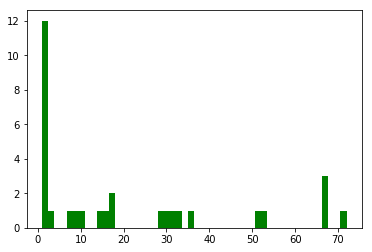

In [422]:
mu, sigma = 100, 15
x = zone_info.spots_amount.values

# the histogram of the data
n, bins, patches = plt.hist(x, 50, facecolor='green')

## Extract more features

In [423]:
weekdays = parking_per_datetime.timestamp.dt.weekday
parking_per_datetime = parking_per_datetime.assign(weekday = weekdays)
parking_per_datetime = parking_per_datetime.assign(hour = parking_per_datetime.timestamp.dt.hour)

In [424]:
dummies = pd.get_dummies(parking_per_datetime, columns=['zone_index','weekday', 'hour'])
dummies.columns

Index(['timestamp', 'parked', 'spots_amount', 'availability', 'zone_index_0',
       'zone_index_1', 'zone_index_2', 'zone_index_3', 'zone_index_4',
       'zone_index_5', 'zone_index_6', 'zone_index_7', 'zone_index_8',
       'zone_index_9', 'zone_index_10', 'zone_index_11', 'zone_index_12',
       'zone_index_13', 'zone_index_14', 'zone_index_15', 'zone_index_16',
       'zone_index_17', 'zone_index_18', 'zone_index_19', 'zone_index_20',
       'zone_index_21', 'zone_index_22', 'zone_index_23', 'zone_index_24',
       'zone_index_25', 'zone_index_26', 'zone_index_27', 'zone_index_28',
       'zone_index_29', 'zone_index_30', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_2

In [425]:
dummies.sort_values(by=['timestamp'], inplace=True)
dummies.drop(columns=['timestamp', 'parked', 'spots_amount',], inplace=True)

## Train a model

In [427]:
training_size = int(len(dummies) * 0.7)
validation_size = int(len(dummies) * 0.15)
test_size = len(dummies) - training_size - validation_size

In [429]:
X_train = dummies.head(training_size)
y_train = X_train['availability']
X_train.drop(columns=['availability'], inplace=True)

In [430]:
validate_and_test = dummies.tail(validation_size + test_size)

In [431]:
X_validate = validate_and_test.head(validation_size)
y_validate = X_validate['availability']
X_validate.drop(columns=['availability'], inplace=True)

In [432]:
X_test = validate_and_test.tail(test_size)
y_test = X_test['availability']
X_test.drop(columns=['availability'], inplace=True)

In [435]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

lambdas = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l1', alpha=lambda_, random_state=100).fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.526874360819


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.523006855448


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.50386750537


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.5


In [321]:
m = models[max(models.keys())]

In [322]:
fdf = pd.DataFrame(X_train.columns)
fdf['k'] = pd.Series(m.coef_[0])
fdf.sort_values(by=['k'], inplace=True)
fdf[fdf.k==0]

,0,k
5,zone_index_5,0.0


In [323]:
from sklearn.ensemble import RandomForestClassifier

ns = [2, 5, 10, 20, 100]

ds = [10, 20, 30, 40, 50, 60, 70]

#n = 100
#d = 2

for n in ns:
    for d in ds:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=100)
        clf.fit(X_train.values, y_train.values)
        y_pred = clf.predict(X_validate.values)
        fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
        auc = metrics.auc(fpr, tpr)
        print('n:{0} d:{1} = auc:{2}'.format(n,d, auc))

n:2 d:10 = auc:0.5166588989008847
n:2 d:20 = auc:0.5582557073353821
n:2 d:30 = auc:0.5705733456490462
n:2 d:40 = auc:0.5705733456490462
n:2 d:50 = auc:0.5705733456490462
n:2 d:60 = auc:0.5705733456490462
n:2 d:70 = auc:0.5705733456490462
n:5 d:10 = auc:0.5027932960893855
n:5 d:20 = auc:0.548529609840247
n:5 d:30 = auc:0.5788523562817744
n:5 d:40 = auc:0.580198565508753
n:5 d:50 = auc:0.580198565508753
n:5 d:60 = auc:0.580198565508753
n:5 d:70 = auc:0.580198565508753
n:10 d:10 = auc:0.5
n:10 d:20 = auc:0.534764884664176
n:10 d:30 = auc:0.5707751009199026
n:10 d:40 = auc:0.5790541115526309
n:10 d:50 = auc:0.5790541115526309
n:10 d:60 = auc:0.5790541115526309
n:10 d:70 = auc:0.5790541115526309
n:20 d:10 = auc:0.5
n:20 d:20 = auc:0.5319715885747907
n:20 d:30 = auc:0.5804003207796095
n:20 d:40 = auc:0.5859869129583803
n:20 d:50 = auc:0.5859869129583803
n:20 d:60 = auc:0.5859869129583803
n:20 d:70 = auc:0.5859869129583803
n:100 d:10 = auc:0.5
n:100 d:20 = auc:0.5291782924854053
n:100 d:30 = 

Random Forest doesn't outperform the previous model (which was Gradient Descent classifier). That is why we will choose the SGD classifier. We will try to add some new features.

First let's add feature interaction and see what will happen.

In [324]:
class FeatureProcessor(object):
    def add_interaction(self, df, columns):
        # collect the columns
        cols = {}

        for c in columns:
            cols[c] = []

        for dfc in df.columns:
            for c in columns:
                if dfc.startswith(c):
                    cols[c].append(dfc)

        keys = []

        for k in cols.keys():
            keys.append(k)

        new_keys = []
        self._combine(keys, 0, new_keys, cols, len(columns), [])

        for n_key in new_keys:
            n_key_name = self._to_name(n_key)
            df[n_key_name] = df.apply(lambda row: self._get_row_val(row, n_key) , axis = 1)

    def _get_row_val(self, row, n_key):
        all_ones = 1
        for nk in n_key:
            if row[nk]!=1:
                all_ones = 0
                break
        return all_ones

    def _to_name(self, key):
        return '_'.join(key)

    def _combine(self, keys, idx, res, cols, n, cur_key):

        if len(cur_key) == n:
            res.append(cur_key)

        if idx >= n:
            return

        for i in range(idx, len(keys)):
            k = keys[i]
            vals = cols[k]
            for j in range(len(vals)):
                self._combine(keys, i+1, res,cols, n, cur_key + [vals[j]])

In [325]:
dummies.columns.get_values()

array(['availability', 'zone_index_0', 'zone_index_1', 'zone_index_2',
       'zone_index_3', 'zone_index_4', 'zone_index_5', 'zone_index_6',
       'zone_index_7', 'zone_index_8', 'zone_index_9', 'zone_index_10',
       'zone_index_11', 'zone_index_12', 'zone_index_13', 'zone_index_14',
       'zone_index_15', 'zone_index_16', 'zone_index_17', 'zone_index_18',
       'zone_index_19', 'zone_index_20', 'zone_index_21', 'zone_index_22',
       'zone_index_23', 'zone_index_24', 'zone_index_25', 'zone_index_26',
       'zone_index_27', 'zone_index_28', 'zone_index_29', 'zone_index_30',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'], dtype=object)

In [326]:
#size = len(dummies)
#sample = dummies.head(100)

In [327]:
fp = FeatureProcessor()
fp.add_interaction(dummies, columns=['weekday', 'hour'])
dummies.columns.get_values()

array(['availability', 'zone_index_0', 'zone_index_1', 'zone_index_2',
       'zone_index_3', 'zone_index_4', 'zone_index_5', 'zone_index_6',
       'zone_index_7', 'zone_index_8', 'zone_index_9', 'zone_index_10',
       'zone_index_11', 'zone_index_12', 'zone_index_13', 'zone_index_14',
       'zone_index_15', 'zone_index_16', 'zone_index_17', 'zone_index_18',
       'zone_index_19', 'zone_index_20', 'zone_index_21', 'zone_index_22',
       'zone_index_23', 'zone_index_24', 'zone_index_25', 'zone_index_26',
       'zone_index_27', 'zone_index_28', 'zone_index_29', 'zone_index_30',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday_0_hour_0', 'wee

In [328]:
len(dummies.columns.get_values())

231

In [329]:
training_size = int(len(dummies) * 0.7)
validation_size = int(len(dummies) * 0.15)
test_size = len(dummies) - training_size - validation_size

In [331]:
X_train = dummies.head(training_size)
y_train = X_train['availability']
X_train.drop(columns=['availability'], inplace=True)

In [332]:
validate_and_test = dummies.tail(validation_size + test_size)

In [333]:
X_validate = validate_and_test.head(validation_size)
y_validate = X_validate['availability']
X_validate.drop(columns=['availability'], inplace=True)

In [334]:
X_test = validate_and_test.tail(test_size)
y_test = X_test['availability']
X_test.drop(columns=['availability'], inplace=True)

In [338]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

lambdas = [0.00000001,0.0000001,0.00000013,0.00000015,0.00000017,0.00000019]

#lambdas = [0.000001,]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l2', alpha=lambda_, random_state=100).fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.644684453066


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.65168333214


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.65720384665


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.643505199143


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.59632179853


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.58396936025
